In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 4
LR = 0.001
MOMENTUM = 0.9
EPOCHS = 2
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PRINT_INTERVAL = 1000

MODEL_SAVE_DIR = "models"

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [4]:
print(len(train_dl))
print(len(test_dl))

12500
2500


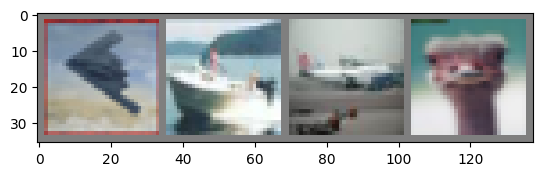

plane ship  plane bird 


In [5]:
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

data_iter = iter(train_dl)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(BATCH_SIZE)))

In [6]:
class BaseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
model = BaseNet()
model.to(DEVICE)

BaseNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

In [9]:
print(len(train_dl), len(test_dl))

12500 2500


In [10]:
num_train_batches = len(train_dl)

In [11]:
for epoch in range(EPOCHS):
    running_loss = 0.0

    for i, data in enumerate(train_dl):
        inputs, labels = data
        optimiser.zero_grad()

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        output = model(inputs)

        loss = criterion(output, labels)

        loss.backward()
        optimiser.step()

        running_loss += loss.item()

        if (i % PRINT_INTERVAL == (PRINT_INTERVAL - 1)) or (i == num_train_batches - 1):
            print(f"Epoch: {epoch + 1} |  Batch: {i + 1}/{num_train_batches} | Loss: {running_loss / ((i + 1) * BATCH_SIZE)}")

Epoch: 1 |  Batch: 1000/12500 | Loss: 0.5743332543373108
Epoch: 1 |  Batch: 2000/12500 | Loss: 0.5551245209872723
Epoch: 1 |  Batch: 3000/12500 | Loss: 0.5286187710066637
Epoch: 1 |  Batch: 4000/12500 | Loss: 0.5056212217770517
Epoch: 1 |  Batch: 5000/12500 | Loss: 0.4885281589090824
Epoch: 1 |  Batch: 6000/12500 | Loss: 0.47560906927163404
Epoch: 1 |  Batch: 7000/12500 | Loss: 0.4642473690286279
Epoch: 1 |  Batch: 8000/12500 | Loss: 0.4540769709665328
Epoch: 1 |  Batch: 9000/12500 | Loss: 0.4455742501459188
Epoch: 1 |  Batch: 10000/12500 | Loss: 0.43847200073376297
Epoch: 1 |  Batch: 11000/12500 | Loss: 0.4312836512164636
Epoch: 1 |  Batch: 12000/12500 | Loss: 0.42524631943150115
Epoch: 1 |  Batch: 12500/12500 | Loss: 0.42249798354774715
Epoch: 2 |  Batch: 1000/12500 | Loss: 0.3441909696608782
Epoch: 2 |  Batch: 2000/12500 | Loss: 0.34109020195528866
Epoch: 2 |  Batch: 3000/12500 | Loss: 0.34073387186477583
Epoch: 2 |  Batch: 4000/12500 | Loss: 0.340163967827335
Epoch: 2 |  Batch: 500

In [12]:
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
model_path = f"{MODEL_SAVE_DIR}/cifar_net.pth"
torch.save(model.state_dict(), model_path)